In [1]:
import numpy as np 
import pandas as pd
import os
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from wordcloud import WordCloud

import spacy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install tqdm
from tqdm.notebook import tqdm

tqdm.pandas() 

In [4]:
data = pd.read_csv(r"C:\Users\natal\OneDrive\Pulpit\Koźmiński\Wiktoria - projekt\ecommerceDataset.csv", header=None)
data.head()

,0,1
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [5]:
data.columns = ['category','description']
data.head()

,category,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [6]:
data.shape

(50425, 2)

In [7]:
data.isnull().sum()

category       0
description    1
dtype: int64

In [8]:
data.dropna(inplace = True)

In [9]:
data.describe(include='O')

,category,description
count,50424,50424
unique,4,27802
top,Household,Think & Grow Rich About the Author NAPOLEON HI...
freq,19313,30


In [10]:
x = data['category'].value_counts()
x

category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: count, dtype: int64

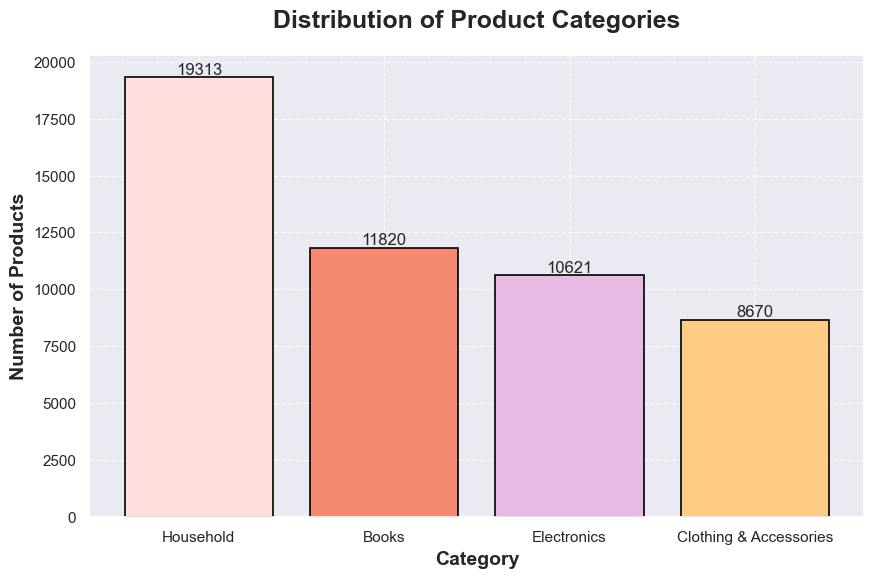

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

categories = data['category'].value_counts().keys()
counts = data['category'].value_counts().values

colors = ['#FFDEDE', '#F48A71', '#E8BAE3', '#FFCC86']

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors, edgecolor='black', linewidth=1.2)

plt.title('Distribution of Product Categories', fontsize=18, fontweight='bold', pad=20)

plt.xlabel('Category', fontsize=14, fontweight='bold')
plt.ylabel('Number of Products', fontsize=14, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, 
             f'{int(height)}', 
             ha='center', va='bottom', fontsize=12)

plt.show()


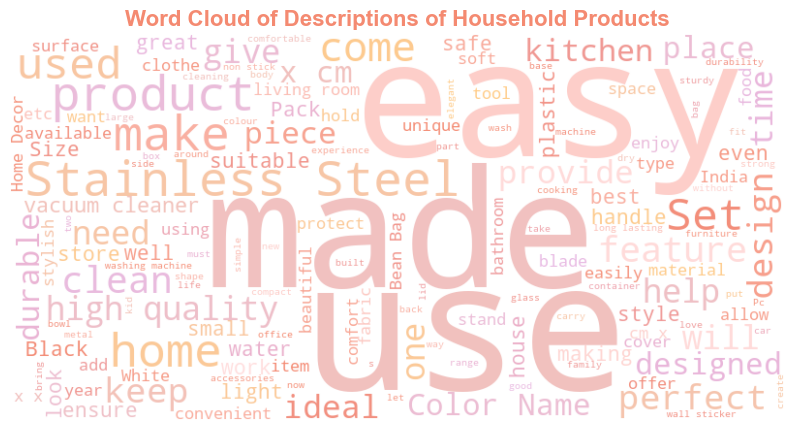

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom", ['#FFDEDE', '#F48A71', '#E8BAE3', '#FFCC86'])

all_text = ' '.join(data[data['category']=='Household']['description'])
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap=custom_cmap, 
    max_words=150, 
    contour_color='#F48A71', 
    contour_width=1
).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Descriptions of Household Products', fontsize=16, fontweight='bold', color='#F48A71')
plt.axis('off')
plt.show()


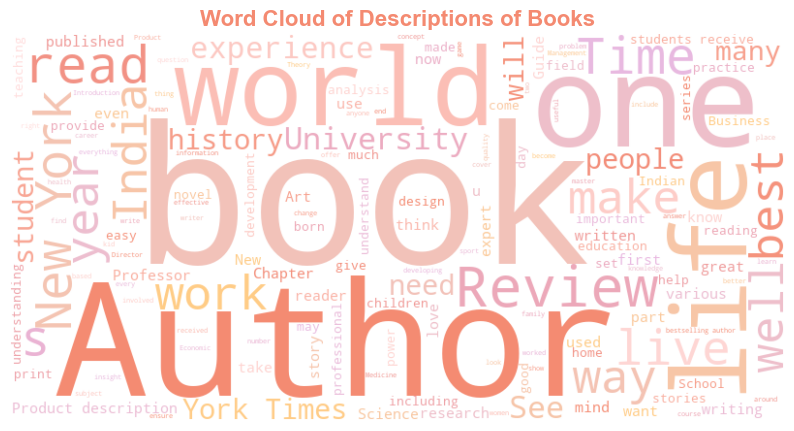

In [14]:
custom_cmap = LinearSegmentedColormap.from_list("custom", ['#FFDEDE', '#F48A71', '#E8BAE3', '#FFCC86'])

all_text = ' '.join(data[data['category']=='Books']['description'])
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',  
    colormap=custom_cmap,  
    max_words=150,  
    contour_color='#F48A71',  
    contour_width=1
).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Descriptions of Books', fontsize=16, fontweight='bold', color='#F48A71')
plt.axis('off')
plt.show()


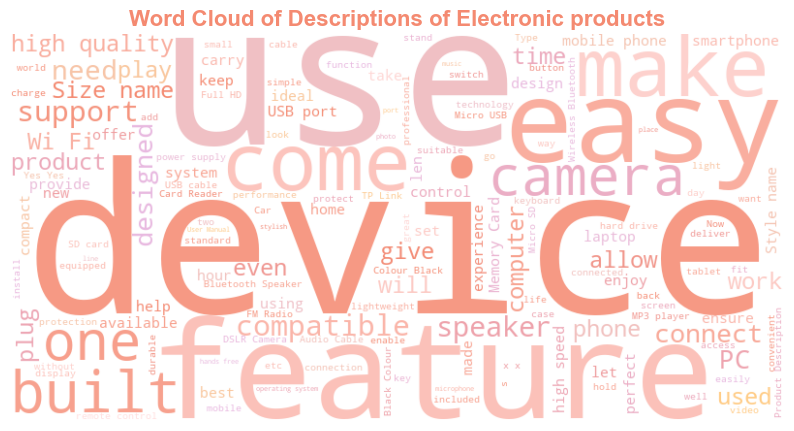

In [16]:
custom_cmap = LinearSegmentedColormap.from_list("custom", ['#FFDEDE', '#F48A71', '#E8BAE3', '#FFCC86'])

all_text = ' '.join(data[data['category']=='Electronics']['description'])
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap=custom_cmap,  
    max_words=150,  
    contour_color='#F48A71', 
    contour_width=1
).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Descriptions of Electronic products', fontsize=16, fontweight='bold', color='#F48A71')
plt.axis('off')
plt.show()


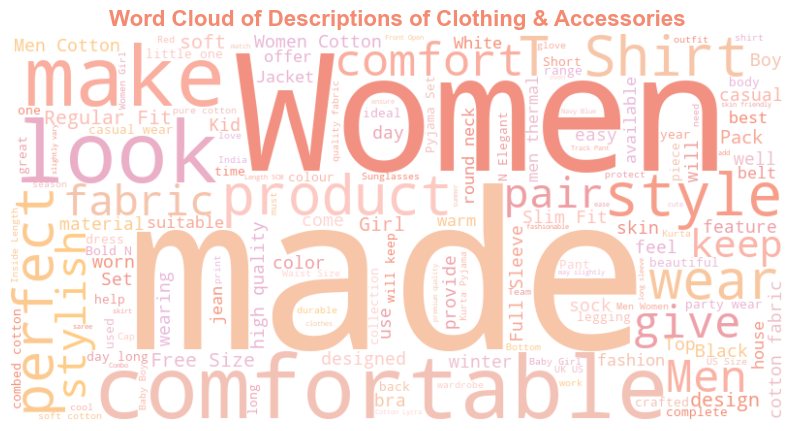

In [18]:
custom_cmap = LinearSegmentedColormap.from_list("custom", ['#FFDEDE', '#F48A71', '#E8BAE3', '#FFCC86'])

all_text = ' '.join(data[data['category']=='Clothing & Accessories']['description'])
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',  
    colormap=custom_cmap,  
    max_words=150,  
    contour_color='#F48A71', 
    contour_width=1
).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Descriptions of Clothing & Accessories', fontsize=16, fontweight='bold', color='#F48A71')
plt.axis('off')
plt.show()

***Data Cleaning***

In [39]:
nlp = spacy.load('en_core_web_sm')

In [44]:
def clean_text_batch(texts):
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=100, n_process=2), total=len(texts), desc="Processing"):
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        cleaned_texts.append(' '.join(tokens))
    return cleaned_texts

In [45]:
data['description'] = clean_text_batch(data['description'].tolist())

Processing:   0%|          | 0/50424 [00:00<?, ?it/s]

In [47]:
labelencoder = LabelEncoder()
data['cat_encoded'] = labelencoder.fit_transform(data['category'])

In [48]:
data[['category','cat_encoded']].value_counts()

category                cat_encoded
Household               3              19313
Books                   0              11820
Electronics             2              10621
Clothing & Accessories  1               8670
Name: count, dtype: int64

In [49]:
X, y = data['description'], data['cat_encoded']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

In [51]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

In [52]:
X_train, y_train = X_train.tolist(), y_train.tolist()
X_val, y_val = X_val.tolist(), y_val.tolist()
X_test, y_test = X_test.tolist(), y_test.tolist()

In [53]:
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train)
X_val_tfidf = TfidfVec.transform(X_val)
X_test_tfidf = TfidfVec.transform(X_test)

In [54]:
def model_score(model, X_train, y_train, X_val, y_val):
    
    model.fit(X_train, y_train)
    y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
    score_train = accuracy_score(y_train, y_train_pred)
    score_val = accuracy_score(y_val, y_val_pred)
    
    print('Model Training Accuracy', score_train)
    print('Model Validation Accuracy', score_val)
    
    return 

In [55]:
xgboost_model = XGBClassifier()
xgboost_ypred = model_score(xgboost_model, X_train_tfidf, y_train, X_val_tfidf, y_val)

Model Training Accuracy 0.9777595194922938
Model Validation Accuracy 0.9584875727128503


In [56]:
rf_model = RandomForestClassifier()
rf_ypred = model_score(rf_model, X_train_tfidf, y_train, X_val_tfidf, y_val)

Model Training Accuracy 1.0
Model Validation Accuracy 0.969460602855632


In [57]:
knn_model = KNeighborsClassifier()
knn_model = model_score(knn_model,X_train_tfidf, y_train, X_val_tfidf, y_val)

Model Training Accuracy 0.9604771078875793
Model Validation Accuracy 0.9420941300898995


In [58]:
lr_model = LogisticRegression()
lr_model = model_score(lr_model,X_train_tfidf, y_train, X_val_tfidf, y_val)

Model Training Accuracy 0.9786378059836809
Model Validation Accuracy 0.9701216287678477


***Model Evaluation***

In [59]:
rf_model.fit(X_train_tfidf, y_train)
y_pred = rf_model.predict(X_test_tfidf)
score_test = accuracy_score(y_test, y_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())

Test accuracy    0.970915


Text(47.25, 0.5, 'Actual')

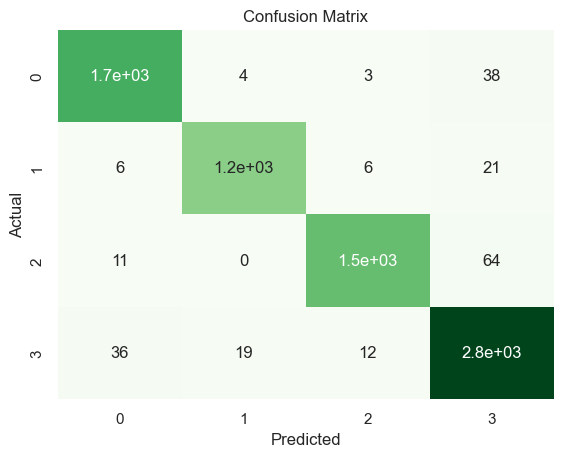

In [60]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [61]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1793
           1       0.98      0.97      0.98      1278
           2       0.99      0.95      0.97      1587
           3       0.96      0.98      0.97      2906

    accuracy                           0.97      7564
   macro avg       0.97      0.97      0.97      7564
weighted avg       0.97      0.97      0.97      7564

